# Integration multi-omic data using scCobra

The following tutorial demonstrates how to use scCobra for *integrating* scRNA-seq and scATAC-seq data
    
There are mainly two steps:

* **Create a gene activity matrix from scATAC-seq data.** This step follows the standard workflow of Signac for scATAC-seq data analysis. We uses the function GeneActivity of Signac and calculate the activity of each gene in the genome by assessing the chromatin accessibility associated with each gene, and create a new gene activity matrix derived from the scATAC-seq data. More details are [here](https://satijalab.org/signac/articles/pbmc_vignette.html).

* **Integrate.** We regard gene expression matrix and gene activity matrix as two batches of one dataset and use scCobra for integration.

For this tutorial, we used a cross-modality PBMC data between scRNA-seq and scATAC-seq provided by 10X Genomics, and both [scRNA-seq](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3) and [scATAC-seq](https://support.10xgenomics.com/single-cell-atac/datasets/1.0.1/atac_v1_pbmc_10k) data are available through the 10x Genomics website.

## Create a gene activity matrix (R)

In [1]:
suppressPackageStartupMessages(library(Signac))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(GenomeInfoDb))
suppressPackageStartupMessages(library(EnsDb.Hsapiens.v75))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
set.seed(1234)
options(warn=-1)

### Pre-processing

We follow the pre-processing workflow of Signac when pre-processing chromatin data. First we creat a Seurat object by two related input files: cell matrix and fragment file. 

In [2]:
counts <- Read10X_h5(filename = "atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "atac_v1_pbmc_10k_singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg19',
  fragments = 'atac_v1_pbmc_10k_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Computing hash



Now add gene annotations to the pbmc object for the human genome. genome is suggested to be as same as the genome for scRNA-seq reads mapping on.

In [4]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg19"

# add the gene information to the object
Annotation(pbmc) <- annotations

Compute QC Metrics. If you don't need to filter cells, ignore this step

In [13]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



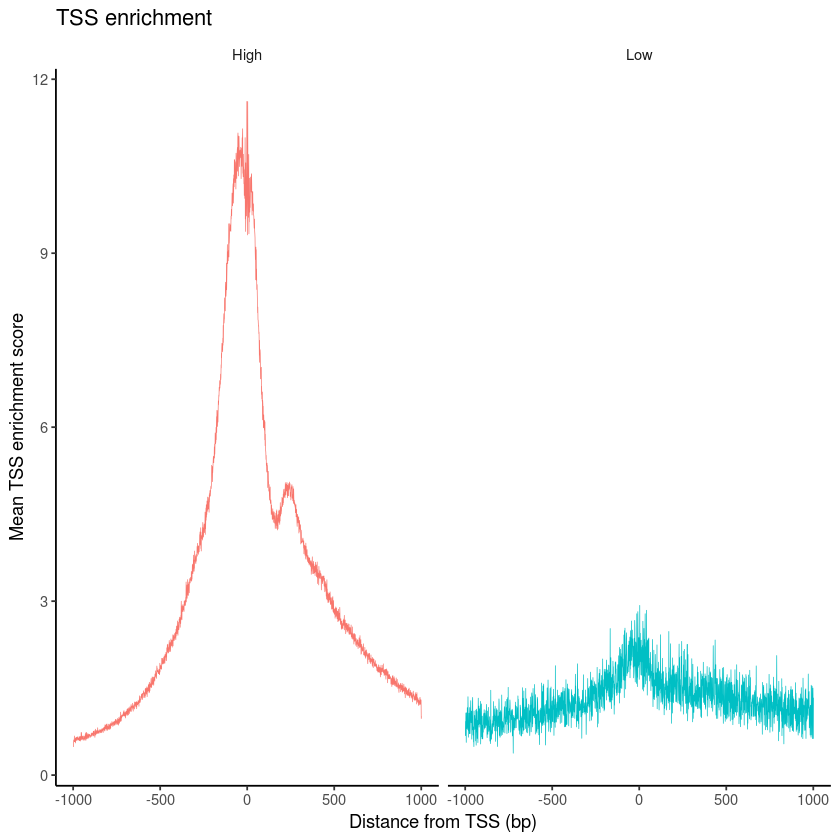

In [14]:
pbmc$high.tss <- ifelse(pbmc$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(pbmc, group.by = 'high.tss') + NoLegend()

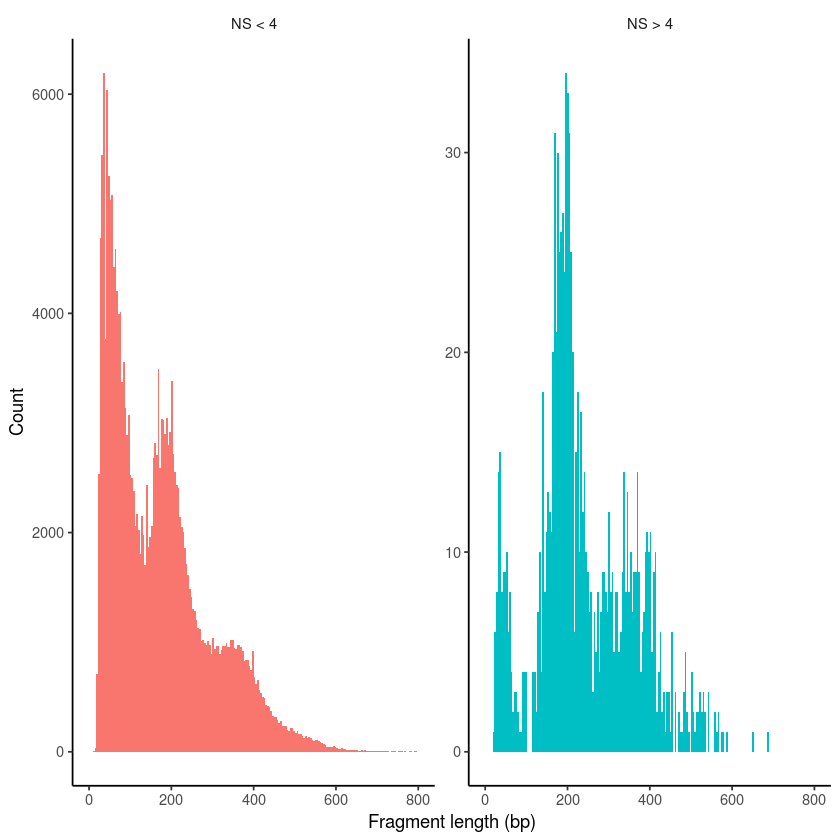

In [15]:
pbmc$nucleosome_group <- ifelse(pbmc$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = pbmc, group.by = 'nucleosome_group')

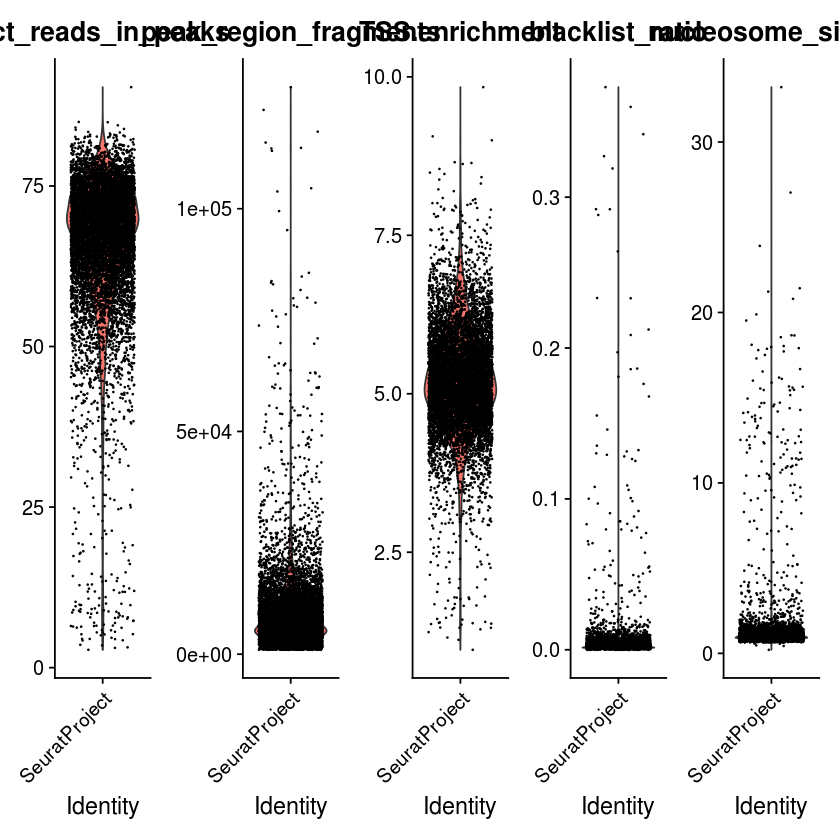

In [16]:
VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

Filter cells that are outliers for the QC metrics.

In [17]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
pbmc

An object of class Seurat 
87561 features across 7060 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

### Calculate gene activity matrix by GeneActivity() function

In [5]:
gene.activities <- GeneActivity(pbmc)

Extracting gene coordinates

Extracting reads overlapping genomic regions



save results

In [ ]:
wk_dir <- './'

In [2]:
write.table(t(gene.activities), paste(wk_dir,"gene_activity_score.txt",sep=''), sep='\t',quote = F)

## Integrate (python)

Now you can use the gene_activity_score together with the gene expression matrix for integration.

You can run scCobra command line directly:
scCobra.py --data_list data1 data2 --batch_categories RNA ATAC -o output_path

* **data1:** path or file of scRNA-seq data
* **data2:** file of gene_activity_score

and here we show the results before integration and after integration.

In [3]:
import sccobra
from scCobra import scCobra
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)
sc.logging.print_header()
plt.rcParams['axes.unicode_minus']=False

scanpy==1.7.0 anndata==0.7.5 umap==0.5.0 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.9.0 leidenalg==0.8.3


First we merge the RNA and ATAC data and add metadata information, and this processed data is available [here](http://zhanglab.net/scalex-tutorial/pbmc_RNA-ATAC.h5ad)

In [ ]:
wk_dir = './'

In [10]:
adata = sc.read_h5ad(wk_dir+'pbmc_RNA-ATAC.h5ad')

#### Before integration

In [11]:
adata

AnnData object with n_obs × n_vars = 16492 × 13928
    obs: 'celltype', 'tech', 'batch'

In [12]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.umap(adata, min_dist=0.1)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)


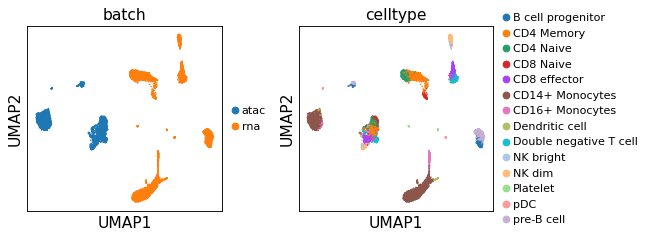

In [15]:
sc.pl.umap(adata,color=['batch','celltype'],legend_fontsize=10, ncols=2)

#### After integration

In [16]:
wk_dir='./' # wk_dir is your local path to store data and results

In [17]:
adata = sccobra(data_list = [wk_dir+'RNA-ATAC.h5ad'],
              min_features=0, 
              min_cells=0, 
              outdir=wk_dir+'/pbmc_RNA_ATAC/',
              show=False,
              gpu=7)

2021-03-26 11:46:17,234 - root - INFO - Raw dataset shape: (16492, 13928)
2021-03-26 11:46:17,237 - root - INFO - Preprocessing
2021-03-26 11:46:17,260 - root - INFO - Filtering cells
Trying to set attribute `.obs` of view, copying.
2021-03-26 11:46:21,627 - root - INFO - Filtering features
2021-03-26 11:46:24,745 - root - INFO - Normalizing total per cell
normalizing counts per cell
    finished (0:00:00)
2021-03-26 11:46:25,022 - root - INFO - Log1p transforming
2021-03-26 11:46:26,014 - root - INFO - Finding variable features
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2021-03-26 11:46:30,637 - root - INFO - Batch specific maxabs scaling
2021-03-26 11:46:32,857 - root - INFO - Processed dataset shape: (16492, 2000)
2021-03-26 11:46:

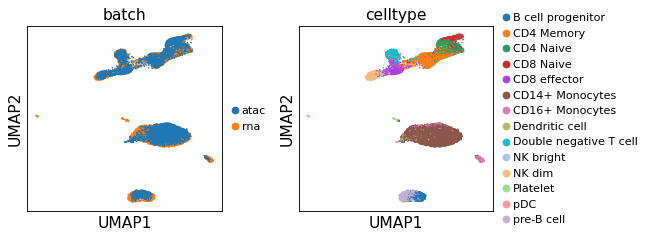

In [20]:
sc.pl.umap(adata,color=['batch','celltype'],legend_fontsize=10, ncols=2)